# Лабораторная работа №7: Семантическая сегментация

## Импорт библиотек

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Установим seed для воспроизводимости
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Проверим доступность GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

c:\Users\Ekaterina\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


Будем использовать датасет Oxford-IIIT Pet Dataset, который содержит изображения 37 категорий домашних животных с соответствующими масками сегментации. Этот датасет хорошо подходит для нашей задачи, так как:
- Имеет реалистичные изображения домашних животных (практическая задача - сегментация питомцев для приложений ветеринарии или фоторедакторов)
- Содержит 7349 изображений (мы возьмем подмножество ~1000 изображений для быстрого обучения)
- Включает маски сегментации для трех классов: животное, граница, фон

##  Загрузка и подготовка данных

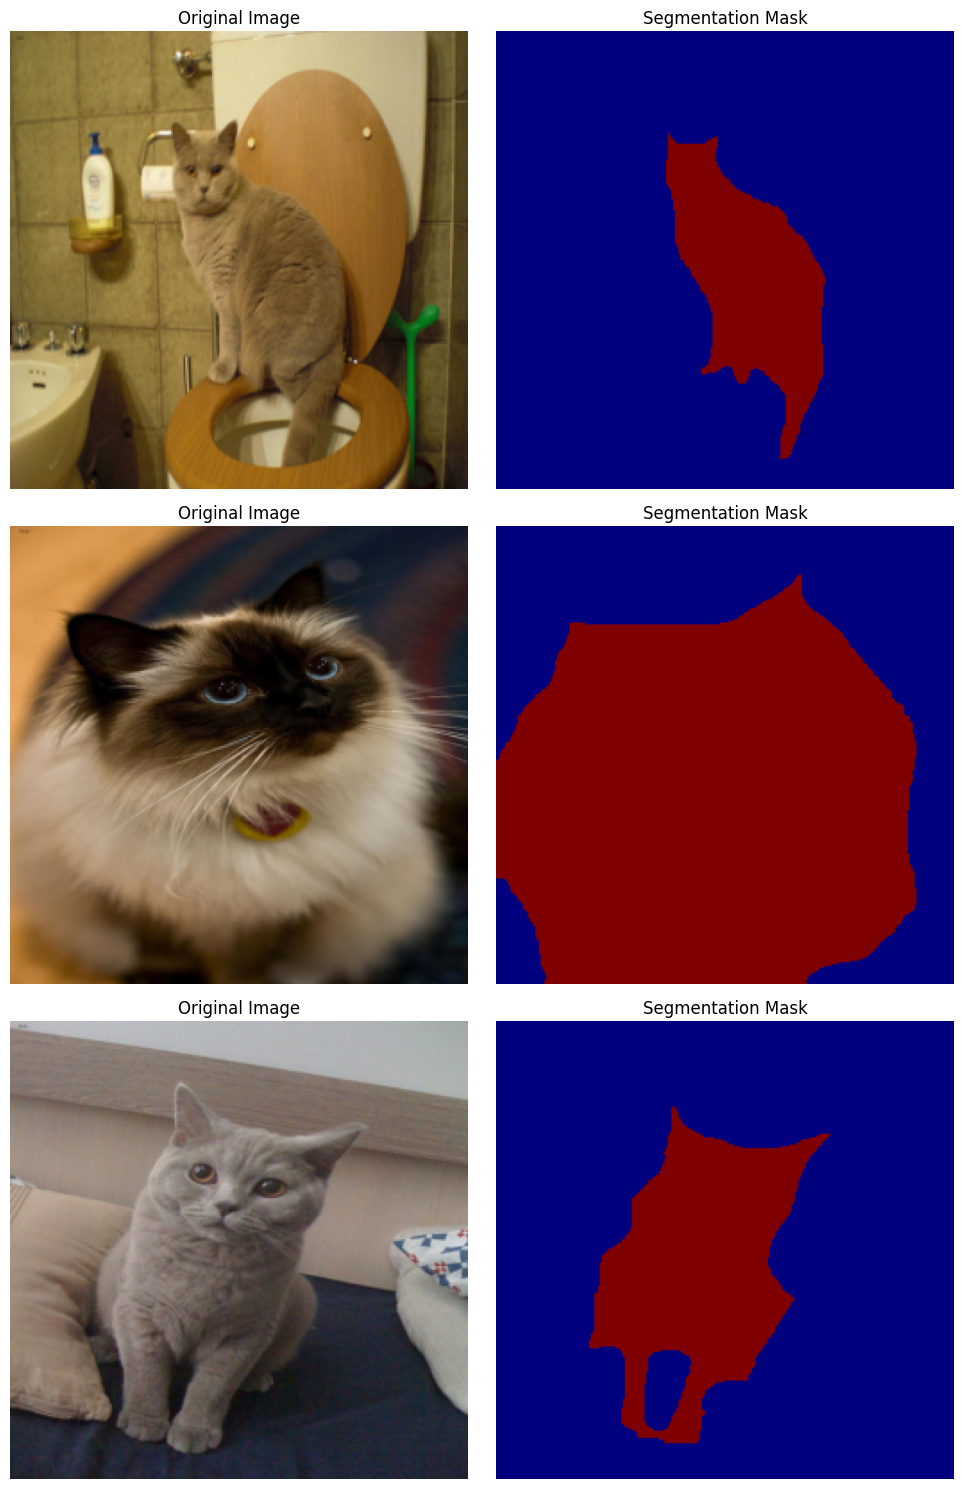

In [24]:
# Dataset класс с фиксированным размером изображений
class OxfordPetDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, subset_size=1000, img_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_size = img_size
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])[:subset_size]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace('.jpg', '.png'))
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)
        
        # Ресайз изображения и маски к фиксированному размеру
        image = image.resize(self.img_size, Image.BILINEAR)
        mask = mask.resize(self.img_size, Image.NEAREST)  # Для масок используем NEAREST, чтобы не интерполировать классы
        
        # Преобразуем маску: 1=pet, 2=border, 3=background -> 0=background, 1=pet
        mask = np.array(mask)
        mask = np.where(mask == 2, 0, mask)  # границу считаем фоном
        mask = np.where(mask == 3, 0, mask)  # фон
        mask = np.where(mask == 1, 1, mask)  # питомец
        
        if self.transform:
            image = self.transform(image)
            mask = torch.from_numpy(mask).long()
            
        return image, mask

# Определим трансформации
basic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Создаем датасет с фиксированным размером 256x256
dataset = OxfordPetDataset(
    image_dir='images',
    mask_dir='annotations/trimaps',
    transform=basic_transform,
    subset_size=1000,
    img_size=(256, 256)
)

# Разделяем на train/val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Создаем DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

def visualize_samples(dataset, num_samples=3):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples*5))
    
    for i in range(num_samples):
        idx = random.randint(0, len(dataset)-1)
        image, mask = dataset[idx]
        
        # Денормализуем изображение
        image = image.numpy().transpose(1, 2, 0)
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)
        
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask.numpy(), cmap='jet')
        axes[i, 1].set_title('Segmentation Mask')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Визуализируем несколько примеров
visualize_samples(train_dataset)

### Выбор метрик качества

Для оценки качества моделей семантической сегментации будем использовать:
1. **Intersection over Union (IoU)** - основная метрика для задач сегментации, показывает площадь пересечения предсказанной и истинной масок, деленную на площадь их объединения
2. **Dice Coefficient (F1-score)** - похожа на IoU, но более чувствительна к перекрытию масок
3. **Pixel Accuracy** - доля правильно классифицированных пикселей (может быть необъективной при несбалансированных классах)

Эти метрики хорошо дополняют друг друга и дают полное представление о качестве сегментации.

## Создание бейзлайна и оценка качества

### Обучение моделей из segmentation_models.pytorch

In [25]:
# Определим модель (Unet с backbone resnet18)
model = smp.Unet(
    encoder_name="resnet18",        # используем предобученный encoder
    encoder_weights="imagenet",    # веса с ImageNet
    in_channels=3,                 # RGB изображения
    classes=2,                     # питомец и фон
).to(device)

# Определим функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

##  Создание бейзлайна и оценка качества

### Обучение модели из segmentation_models.pytorch

In [28]:
# Функции для вычисления метрик
def calculate_metrics(preds, masks):
    preds = torch.argmax(preds, dim=1)
    
    # Вычисляем метрики с использованием smp.metrics
    tp, fp, fn, tn = smp.metrics.get_stats(preds.long(), masks.long(), mode='multiclass', num_classes=2)
    
    iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction='micro')
    f1 = smp.metrics.f1_score(tp, fp, fn, tn, reduction='micro')
    accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction='micro')
    
    return iou, f1, accuracy

# Функция для обучения
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10):
    train_losses = []
    val_losses = []
    train_metrics = {'iou': [], 'f1': [], 'accuracy': []}
    val_metrics = {'iou': [], 'f1': [], 'accuracy': []}
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_iou, running_f1, running_acc = 0.0, 0.0, 0.0
        
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Вычисляем метрики
            iou, f1, acc = calculate_metrics(outputs, masks)
            running_iou += iou.item()
            running_f1 += f1.item()
            running_acc += acc.item()
        
        # Средние значения по эпохе
        epoch_loss = running_loss / len(train_loader)
        epoch_iou = running_iou / len(train_loader)
        epoch_f1 = running_f1 / len(train_loader)
        epoch_acc = running_acc / len(train_loader)
        
        train_losses.append(epoch_loss)
        train_metrics['iou'].append(epoch_iou)
        train_metrics['f1'].append(epoch_f1)
        train_metrics['accuracy'].append(epoch_acc)
        
        # Валидация
        model.eval()
        val_loss = 0.0
        val_iou, val_f1, val_acc = 0.0, 0.0, 0.0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                iou, f1, acc = calculate_metrics(outputs, masks)
                val_iou += iou.item()
                val_f1 += f1.item()
                val_acc += acc.item()
        
        val_loss /= len(val_loader)
        val_iou /= len(val_loader)
        val_f1 /= len(val_loader)
        val_acc /= len(val_loader)
        
        val_losses.append(val_loss)
        val_metrics['iou'].append(val_iou)
        val_metrics['f1'].append(val_f1)
        val_metrics['accuracy'].append(val_acc)
        
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Train IoU: {epoch_iou:.4f} | Val IoU: {val_iou:.4f}")
        print(f"Train F1: {epoch_f1:.4f} | Val F1: {val_f1:.4f}")
        print(f"Train Acc: {epoch_acc:.4f} | Val Acc: {val_acc:.4f}")
        print("-" * 50)
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_metrics': train_metrics,
        'val_metrics': val_metrics
    }

In [30]:
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10)

Epoch 1/10: 100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


Epoch 1/10
Train Loss: 0.2839 | Val Loss: 0.3814
Train IoU: 0.7933 | Val IoU: 0.7458
Train F1: 0.8835 | Val F1: 0.8528
Train Acc: 0.8835 | Val Acc: 0.8528
--------------------------------------------------


Epoch 2/10: 100%|██████████| 100/100 [01:46<00:00,  1.06s/it]


Epoch 2/10
Train Loss: 0.1909 | Val Loss: 0.2365
Train IoU: 0.8591 | Val IoU: 0.8446
Train F1: 0.9235 | Val F1: 0.9153
Train Acc: 0.9235 | Val Acc: 0.9153
--------------------------------------------------


Epoch 3/10: 100%|██████████| 100/100 [01:47<00:00,  1.07s/it]


Epoch 3/10
Train Loss: 0.1755 | Val Loss: 0.2059
Train IoU: 0.8743 | Val IoU: 0.8418
Train F1: 0.9324 | Val F1: 0.9137
Train Acc: 0.9324 | Val Acc: 0.9137
--------------------------------------------------


Epoch 4/10: 100%|██████████| 100/100 [01:47<00:00,  1.08s/it]


Epoch 4/10
Train Loss: 0.1743 | Val Loss: 0.1830
Train IoU: 0.8727 | Val IoU: 0.8748
Train F1: 0.9315 | Val F1: 0.9329
Train Acc: 0.9315 | Val Acc: 0.9329
--------------------------------------------------


Epoch 5/10: 100%|██████████| 100/100 [01:47<00:00,  1.08s/it]


Epoch 5/10
Train Loss: 0.1655 | Val Loss: 0.1738
Train IoU: 0.8793 | Val IoU: 0.8711
Train F1: 0.9352 | Val F1: 0.9308
Train Acc: 0.9352 | Val Acc: 0.9308
--------------------------------------------------


Epoch 6/10: 100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


Epoch 6/10
Train Loss: 0.1603 | Val Loss: 0.1923
Train IoU: 0.8822 | Val IoU: 0.8583
Train F1: 0.9370 | Val F1: 0.9232
Train Acc: 0.9370 | Val Acc: 0.9232
--------------------------------------------------


Epoch 7/10: 100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


Epoch 7/10
Train Loss: 0.1239 | Val Loss: 0.1866
Train IoU: 0.9089 | Val IoU: 0.8691
Train F1: 0.9521 | Val F1: 0.9296
Train Acc: 0.9521 | Val Acc: 0.9296
--------------------------------------------------


Epoch 8/10: 100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


Epoch 8/10
Train Loss: 0.1282 | Val Loss: 0.1652
Train IoU: 0.9033 | Val IoU: 0.8782
Train F1: 0.9489 | Val F1: 0.9346
Train Acc: 0.9489 | Val Acc: 0.9346
--------------------------------------------------


Epoch 9/10: 100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


Epoch 9/10
Train Loss: 0.1103 | Val Loss: 0.1643
Train IoU: 0.9174 | Val IoU: 0.8816
Train F1: 0.9568 | Val F1: 0.9367
Train Acc: 0.9568 | Val Acc: 0.9367
--------------------------------------------------


Epoch 10/10: 100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


Epoch 10/10
Train Loss: 0.1058 | Val Loss: 0.1743
Train IoU: 0.9195 | Val IoU: 0.8791
Train F1: 0.9579 | Val F1: 0.9352
Train Acc: 0.9579 | Val Acc: 0.9352
--------------------------------------------------


### Визуализация результатов обучения

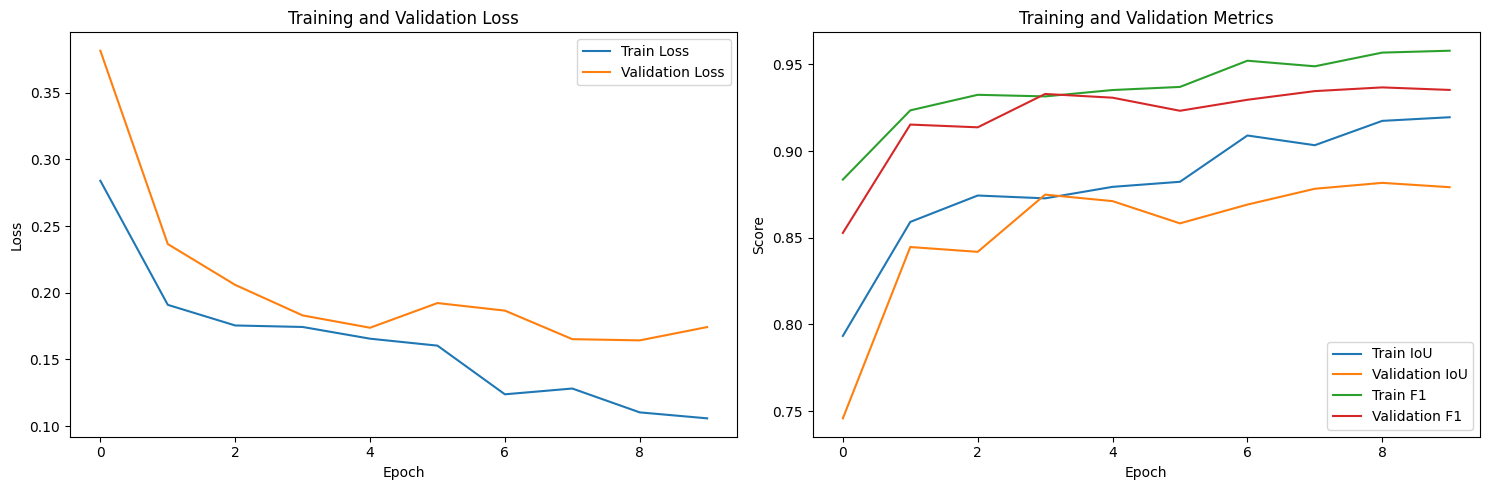

In [31]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Потери
    axes[0].plot(history['train_losses'], label='Train Loss')
    axes[0].plot(history['val_losses'], label='Validation Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    # Метрики
    axes[1].plot(history['train_metrics']['iou'], label='Train IoU')
    axes[1].plot(history['val_metrics']['iou'], label='Validation IoU')
    axes[1].plot(history['train_metrics']['f1'], label='Train F1')
    axes[1].plot(history['val_metrics']['f1'], label='Validation F1')
    axes[1].set_title('Training and Validation Metrics')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Score')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

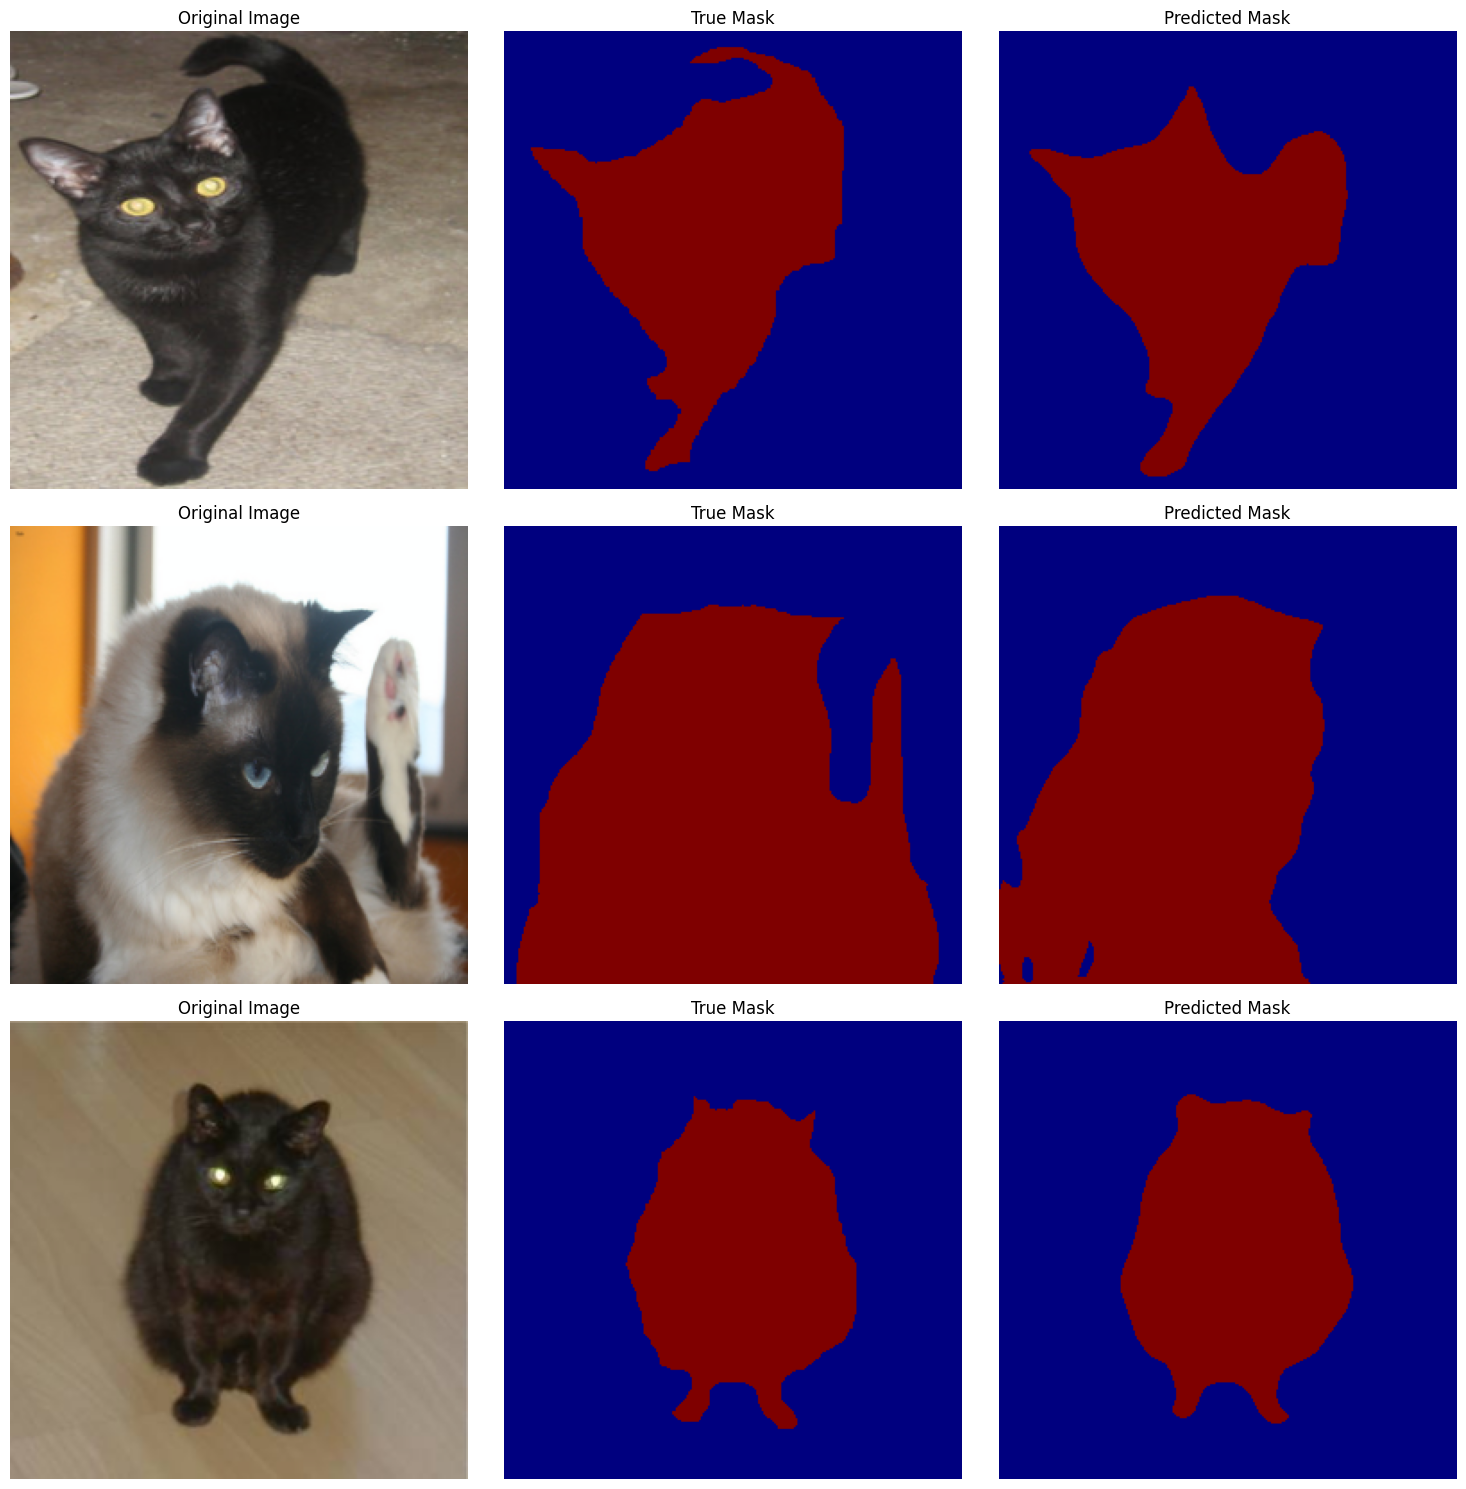

In [32]:
# Визуализация предсказаний на валидационных данных
def visualize_predictions(model, dataset, num_samples=3):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples*5))
    
    for i in range(num_samples):
        idx = random.randint(0, len(dataset)-1)
        image, true_mask = dataset[idx]
        
        with torch.no_grad():
            image = image.unsqueeze(0).to(device)
            pred = model(image)
            pred_mask = torch.argmax(pred, dim=1).squeeze(0).cpu().numpy()
        
        # Денормализуем изображение
        img = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(true_mask.numpy(), cmap='jet')
        axes[i, 1].set_title('True Mask')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_mask, cmap='jet')
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_dataset)

### Оценка качества моделей

In [33]:
# Финальная оценка на валидационном наборе
def evaluate_model(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_iou, total_f1, total_acc = 0.0, 0.0, 0.0
    
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            
            iou, f1, acc = calculate_metrics(outputs, masks)
            total_iou += iou.item()
            total_f1 += f1.item()
            total_acc += acc.item()
    
    avg_loss = total_loss / len(loader)
    avg_iou = total_iou / len(loader)
    avg_f1 = total_f1 / len(loader)
    avg_acc = total_acc / len(loader)
    
    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"IoU: {avg_iou:.4f}")
    print(f"F1 Score: {avg_f1:.4f}")
    print(f"Accuracy: {avg_acc:.4f}")
    
    return avg_loss, avg_iou, avg_f1, avg_acc

val_loss, val_iou, val_f1, val_acc = evaluate_model(model, val_loader, criterion)

# Сохраним результаты бейзлайна
baseline_results = {
    'loss': val_loss,
    'iou': val_iou,
    'f1': val_f1,
    'accuracy': val_acc
}

Validation Loss: 0.1743
IoU: 0.8791
F1 Score: 0.9352
Accuracy: 0.9352


## Улучшение бейзлайна

1. **Аугментация данных**: Добавим случайные аугментации (горизонтальные отражения, повороты, изменения яркости/контраста) для увеличения разнообразия данных
2. **Изменение функции потерь**: Используем комбинацию Dice Loss и CrossEntropy Loss для лучшей оптимизации метрик сегментации
3. **Оптимизация гиперпараметров**: Увеличим количество эпох и добавим раннюю остановку
4. **Использование предобученных весов**: Попробуем более мощный backbone (resnet34)

In [34]:
# Определим улучшенные трансформации с аугментациями
augmented_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Создаем новый датасет с аугментациями
augmented_dataset = OxfordPetDataset(
    image_dir='images',
    mask_dir='annotations/trimaps',
    transform=augmented_transform,
    subset_size=1000
)

# Разделяем на train/val
train_aug_dataset, val_aug_dataset = random_split(augmented_dataset, [train_size, val_size])
train_aug_loader = DataLoader(train_aug_dataset, batch_size=8, shuffle=True)
val_aug_loader = DataLoader(val_aug_dataset, batch_size=8, shuffle=False)


In [35]:
# Определим комбинированную функцию потерь
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        
    def forward(self, inputs, targets, smooth=1):
        # Flatten label and prediction tensors
        inputs = inputs.reshape(-1)
        targets = targets.reshape(-1)
        
        # BCE loss
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='mean')
        
        # Dice loss
        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        
        return bce_loss + dice_loss

# Для многоклассовой сегментации
class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
        self.dice = smp.losses.DiceLoss(mode='multiclass')
        
    def forward(self, inputs, targets):
        return 0.5 * self.cross_entropy(inputs, targets) + 0.5 * self.dice(inputs, targets)

In [36]:
# Создаем улучшенную модель (Unet с resnet34)
improved_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=2,
).to(device)

# Комбинированная функция потерь
criterion = CombinedLoss()
optimizer = Adam(improved_model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

In [37]:
# Добавим раннюю остановку
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [38]:
# Обучаем улучшенную модель
early_stopping = EarlyStopping(patience=5, min_delta=0.001)

improved_history = {
    'train_losses': [],
    'val_losses': [],
    'train_metrics': {'iou': [], 'f1': [], 'accuracy': []},
    'val_metrics': {'iou': [], 'f1': [], 'accuracy': []}
}

epochs = 15
for epoch in range(epochs):
    improved_model.train()
    running_loss = 0.0
    running_iou, running_f1, running_acc = 0.0, 0.0, 0.0
    
    for images, masks in tqdm(train_aug_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = improved_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        iou, f1, acc = calculate_metrics(outputs, masks)
        running_iou += iou.item()
        running_f1 += f1.item()
        running_acc += acc.item()
    
    # Средние значения по эпохе
    epoch_loss = running_loss / len(train_aug_loader)
    epoch_iou = running_iou / len(train_aug_loader)
    epoch_f1 = running_f1 / len(train_aug_loader)
    epoch_acc = running_acc / len(train_aug_loader)
    
    improved_history['train_losses'].append(epoch_loss)
    improved_history['train_metrics']['iou'].append(epoch_iou)
    improved_history['train_metrics']['f1'].append(epoch_f1)
    improved_history['train_metrics']['accuracy'].append(epoch_acc)
    
    # Валидация
    improved_model.eval()
    val_loss = 0.0
    val_iou, val_f1, val_acc = 0.0, 0.0, 0.0
    
    with torch.no_grad():
        for images, masks in val_aug_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = improved_model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            
            iou, f1, acc = calculate_metrics(outputs, masks)
            val_iou += iou.item()
            val_f1 += f1.item()
            val_acc += acc.item()
    
    val_loss /= len(val_aug_loader)
    val_iou /= len(val_aug_loader)
    val_f1 /= len(val_aug_loader)
    val_acc /= len(val_aug_loader)
    
    improved_history['val_losses'].append(val_loss)
    improved_history['val_metrics']['iou'].append(val_iou)
    improved_history['val_metrics']['f1'].append(val_f1)
    improved_history['val_metrics']['accuracy'].append(val_acc)
    
    scheduler.step(val_loss)
    early_stopping(val_loss)
    
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train IoU: {epoch_iou:.4f} | Val IoU: {val_iou:.4f}")
    print(f"Train F1: {epoch_f1:.4f} | Val F1: {val_f1:.4f}")
    print(f"Train Acc: {epoch_acc:.4f} | Val Acc: {val_acc:.4f}")
    print("-" * 50)
    
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break


Epoch 1/15: 100%|██████████| 100/100 [02:15<00:00,  1.36s/it]


Epoch 1/15
Train Loss: 0.3906 | Val Loss: 0.3738
Train IoU: 0.6524 | Val IoU: 0.6714
Train F1: 0.7877 | Val F1: 0.8018
Train Acc: 0.7877 | Val Acc: 0.8018
--------------------------------------------------


Epoch 2/15: 100%|██████████| 100/100 [02:19<00:00,  1.40s/it]


Epoch 2/15
Train Loss: 0.3441 | Val Loss: 0.3487
Train IoU: 0.6909 | Val IoU: 0.6810
Train F1: 0.8163 | Val F1: 0.8096
Train Acc: 0.8163 | Val Acc: 0.8096
--------------------------------------------------


Epoch 3/15: 100%|██████████| 100/100 [02:25<00:00,  1.45s/it]


Epoch 3/15
Train Loss: 0.3263 | Val Loss: 0.3432
Train IoU: 0.7061 | Val IoU: 0.6943
Train F1: 0.8270 | Val F1: 0.8187
Train Acc: 0.8270 | Val Acc: 0.8187
--------------------------------------------------


Epoch 4/15: 100%|██████████| 100/100 [02:14<00:00,  1.35s/it]


Epoch 4/15
Train Loss: 0.3201 | Val Loss: 0.3262
Train IoU: 0.7125 | Val IoU: 0.7083
Train F1: 0.8315 | Val F1: 0.8285
Train Acc: 0.8315 | Val Acc: 0.8285
--------------------------------------------------


Epoch 5/15: 100%|██████████| 100/100 [02:34<00:00,  1.54s/it]


Epoch 5/15
Train Loss: 0.3089 | Val Loss: 0.3142
Train IoU: 0.7199 | Val IoU: 0.7155
Train F1: 0.8365 | Val F1: 0.8339
Train Acc: 0.8365 | Val Acc: 0.8339
--------------------------------------------------


Epoch 6/15: 100%|██████████| 100/100 [02:43<00:00,  1.63s/it]


Epoch 6/15
Train Loss: 0.3006 | Val Loss: 0.3341
Train IoU: 0.7263 | Val IoU: 0.6993
Train F1: 0.8409 | Val F1: 0.8224
Train Acc: 0.8409 | Val Acc: 0.8224
--------------------------------------------------


Epoch 7/15: 100%|██████████| 100/100 [02:30<00:00,  1.50s/it]


Epoch 7/15
Train Loss: 0.2986 | Val Loss: 0.3045
Train IoU: 0.7247 | Val IoU: 0.7051
Train F1: 0.8395 | Val F1: 0.8265
Train Acc: 0.8395 | Val Acc: 0.8265
--------------------------------------------------


Epoch 8/15: 100%|██████████| 100/100 [02:45<00:00,  1.66s/it]


Epoch 8/15
Train Loss: 0.2932 | Val Loss: 0.3147
Train IoU: 0.7300 | Val IoU: 0.7011
Train F1: 0.8431 | Val F1: 0.8237
Train Acc: 0.8431 | Val Acc: 0.8237
--------------------------------------------------


Epoch 9/15: 100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


Epoch 9/15
Train Loss: 0.2904 | Val Loss: 0.3606
Train IoU: 0.7313 | Val IoU: 0.6713
Train F1: 0.8441 | Val F1: 0.8023
Train Acc: 0.8441 | Val Acc: 0.8023
--------------------------------------------------


Epoch 10/15: 100%|██████████| 100/100 [02:14<00:00,  1.34s/it]


Epoch 10/15
Train Loss: 0.2826 | Val Loss: 0.2980
Train IoU: 0.7382 | Val IoU: 0.7225
Train F1: 0.8488 | Val F1: 0.8382
Train Acc: 0.8488 | Val Acc: 0.8382
--------------------------------------------------


Epoch 11/15: 100%|██████████| 100/100 [02:13<00:00,  1.34s/it]


Epoch 11/15
Train Loss: 0.2762 | Val Loss: 0.2923
Train IoU: 0.7420 | Val IoU: 0.7285
Train F1: 0.8512 | Val F1: 0.8423
Train Acc: 0.8512 | Val Acc: 0.8423
--------------------------------------------------


Epoch 12/15: 100%|██████████| 100/100 [02:14<00:00,  1.35s/it]


Epoch 12/15
Train Loss: 0.2839 | Val Loss: 0.2946
Train IoU: 0.7371 | Val IoU: 0.7241
Train F1: 0.8479 | Val F1: 0.8394
Train Acc: 0.8479 | Val Acc: 0.8394
--------------------------------------------------


Epoch 13/15: 100%|██████████| 100/100 [02:18<00:00,  1.38s/it]


Epoch 13/15
Train Loss: 0.2693 | Val Loss: 0.2879
Train IoU: 0.7442 | Val IoU: 0.7264
Train F1: 0.8528 | Val F1: 0.8409
Train Acc: 0.8528 | Val Acc: 0.8409
--------------------------------------------------


Epoch 14/15: 100%|██████████| 100/100 [02:14<00:00,  1.34s/it]


Epoch 14/15
Train Loss: 0.2664 | Val Loss: 0.2860
Train IoU: 0.7495 | Val IoU: 0.7307
Train F1: 0.8563 | Val F1: 0.8438
Train Acc: 0.8563 | Val Acc: 0.8438
--------------------------------------------------


Epoch 15/15: 100%|██████████| 100/100 [02:14<00:00,  1.35s/it]


Epoch 15/15
Train Loss: 0.2626 | Val Loss: 0.2813
Train IoU: 0.7523 | Val IoU: 0.7319
Train F1: 0.8581 | Val F1: 0.8445
Train Acc: 0.8581 | Val Acc: 0.8445
--------------------------------------------------


### Визуализация результатов улучшенной модели

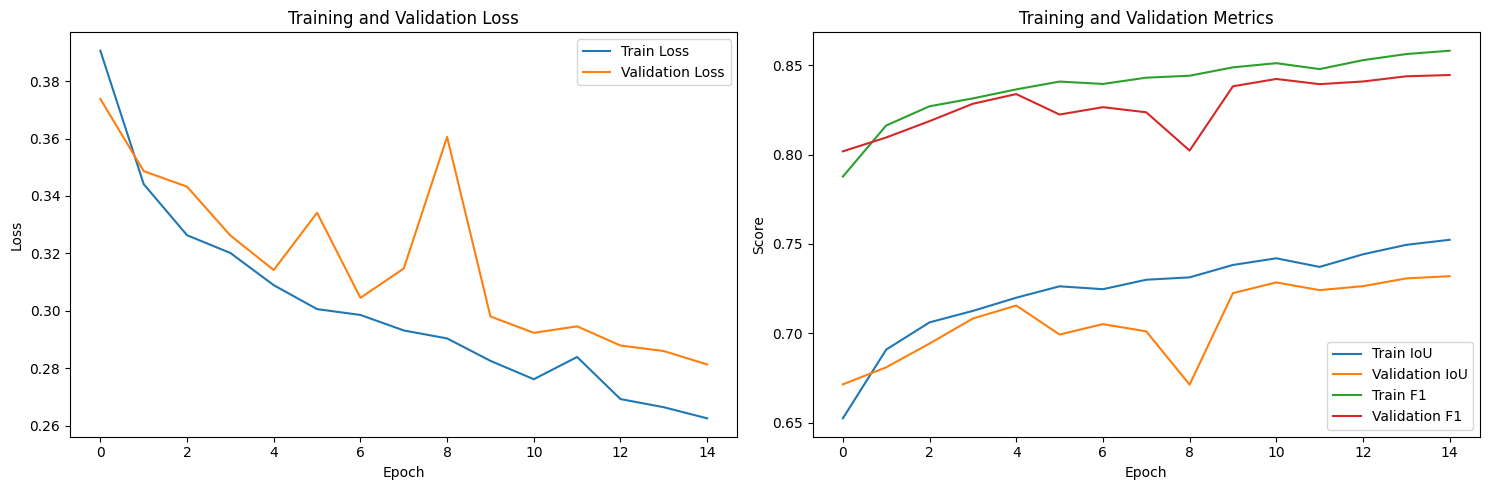

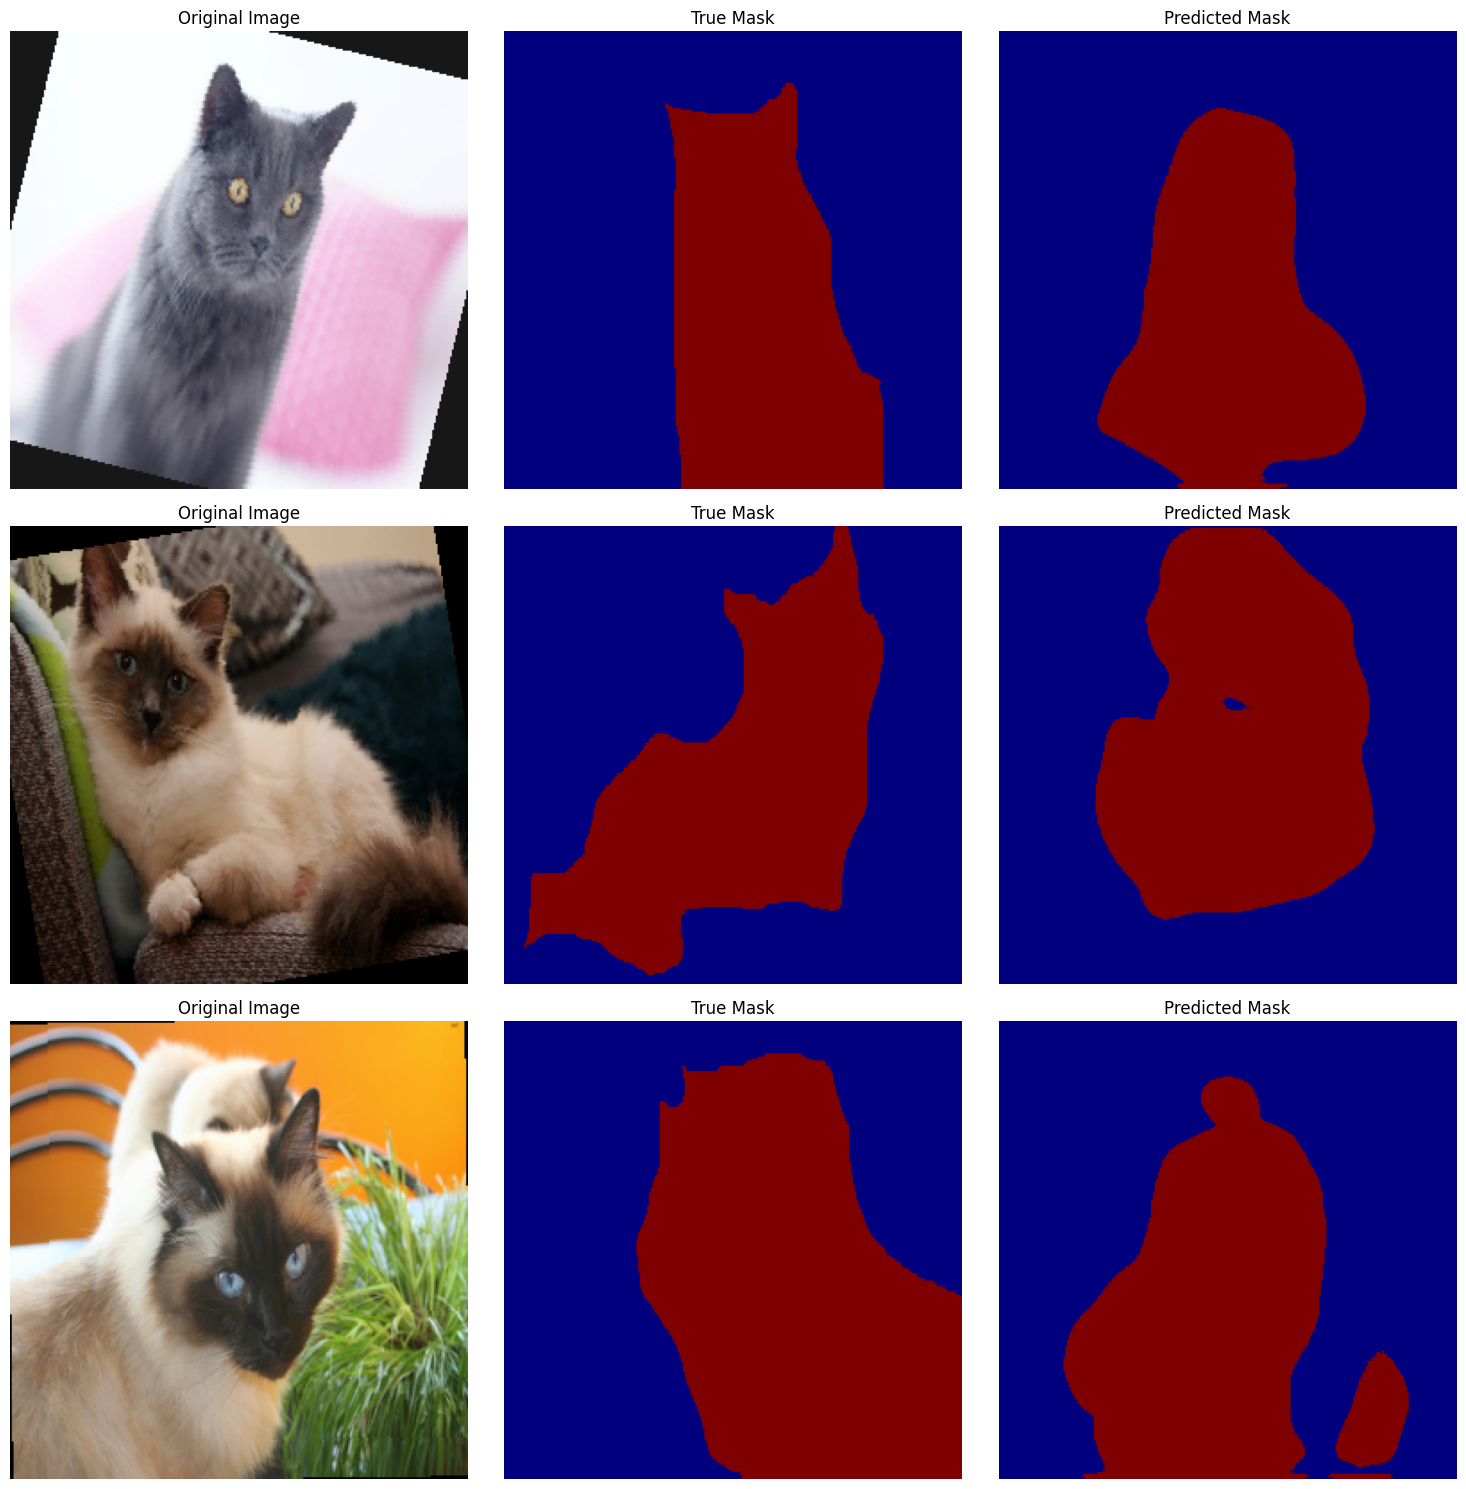

In [39]:
# Визуализация результатов улучшенной модели
plot_training_history(improved_history)

# Визуализация предсказаний улучшенной модели
visualize_predictions(improved_model, val_aug_dataset)

### Финальная оценка улучшенной модели

In [40]:
# Финальная оценка улучшенной модели
val_loss_improved, val_iou_improved, val_f1_improved, val_acc_improved = evaluate_model(
    improved_model, val_aug_loader, criterion
)

# Сохраним результаты улучшенной модели
improved_results = {
    'loss': val_loss_improved,
    'iou': val_iou_improved,
    'f1': val_f1_improved,
    'accuracy': val_acc_improved
}

Validation Loss: 0.2749
IoU: 0.7389
F1 Score: 0.8492
Accuracy: 0.8492


### Сравнение результатов

Comparison between Baseline and Improved Models:
Metric		Baseline	Improved	Difference
Loss		0.1743		0.2749		0.1006
IoU		0.8791		0.7389		-0.1402
F1		0.9352		0.8492		-0.0860
Accuracy	0.9352		0.8492		-0.0860


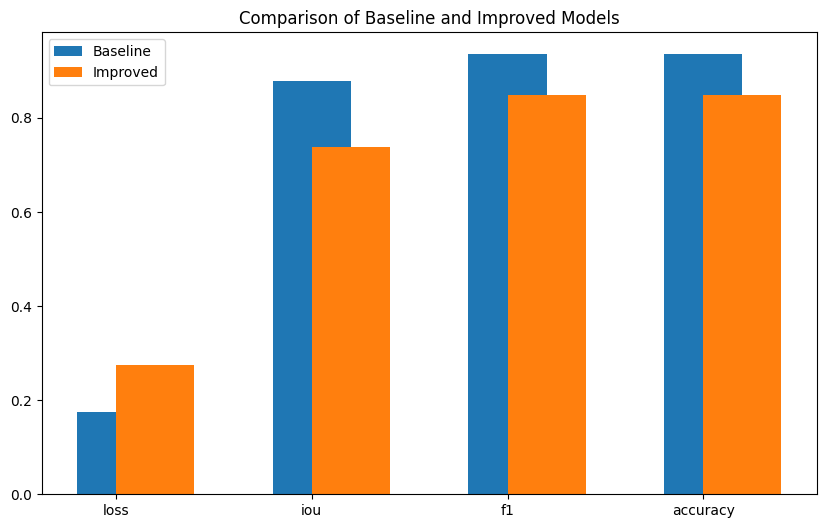

In [41]:
# Сравнение бейзлайна и улучшенной модели
print("Comparison between Baseline and Improved Models:")
print(f"Metric\t\tBaseline\tImproved\tDifference")
print(f"Loss\t\t{baseline_results['loss']:.4f}\t\t{improved_results['loss']:.4f}\t\t{improved_results['loss'] - baseline_results['loss']:.4f}")
print(f"IoU\t\t{baseline_results['iou']:.4f}\t\t{improved_results['iou']:.4f}\t\t{improved_results['iou'] - baseline_results['iou']:.4f}")
print(f"F1\t\t{baseline_results['f1']:.4f}\t\t{improved_results['f1']:.4f}\t\t{improved_results['f1'] - baseline_results['f1']:.4f}")
print(f"Accuracy\t{baseline_results['accuracy']:.4f}\t\t{improved_results['accuracy']:.4f}\t\t{improved_results['accuracy'] - baseline_results['accuracy']:.4f}")

# Визуализация сравнения
metrics = ['loss', 'iou', 'f1', 'accuracy']
baseline_values = [baseline_results[m] for m in metrics]
improved_values = [improved_results[m] for m in metrics]

x = range(len(metrics))
plt.figure(figsize=(10, 6))
plt.bar(x, baseline_values, width=0.4, label='Baseline', align='center')
plt.bar(x, improved_values, width=0.4, label='Improved', align='edge')
plt.xticks(x, metrics)
plt.title('Comparison of Baseline and Improved Models')
plt.legend()
plt.show()

## Самостоятельная имплементация модели

### Реализуем упрощенную версию U-Net

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        return self.conv(x)

class CustomUNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=2, bilinear=True):
        super(CustomUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [50]:
# Создаем модель
custom_model = CustomUNet(n_channels=3, n_classes=2).to(device)

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = Adam(custom_model.parameters(), lr=0.001)

# Обучаем модель
custom_history = train_model(custom_model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=5)

Epoch 1/5: 100%|██████████| 100/100 [07:34<00:00,  4.55s/it]


Epoch 1/5
Train Loss: 0.5686 | Val Loss: 0.5504
Train IoU: 0.5357 | Val IoU: 0.5470
Train F1: 0.6946 | Val F1: 0.7062
Train Acc: 0.6946 | Val Acc: 0.7062
--------------------------------------------------


Epoch 2/5: 100%|██████████| 100/100 [07:33<00:00,  4.54s/it]


Epoch 2/5
Train Loss: 0.4782 | Val Loss: 0.4727
Train IoU: 0.6272 | Val IoU: 0.6286
Train F1: 0.7696 | Val F1: 0.7711
Train Acc: 0.7696 | Val Acc: 0.7711
--------------------------------------------------


Epoch 3/5: 100%|██████████| 100/100 [07:26<00:00,  4.46s/it]


Epoch 3/5
Train Loss: 0.4578 | Val Loss: 0.4604
Train IoU: 0.6459 | Val IoU: 0.6439
Train F1: 0.7841 | Val F1: 0.7827
Train Acc: 0.7841 | Val Acc: 0.7827
--------------------------------------------------


Epoch 4/5: 100%|██████████| 100/100 [07:26<00:00,  4.46s/it]


Epoch 4/5
Train Loss: 0.4471 | Val Loss: 0.4922
Train IoU: 0.6562 | Val IoU: 0.6267
Train F1: 0.7914 | Val F1: 0.7698
Train Acc: 0.7914 | Val Acc: 0.7698
--------------------------------------------------


Epoch 5/5: 100%|██████████| 100/100 [07:26<00:00,  4.46s/it]


Epoch 5/5
Train Loss: 0.4417 | Val Loss: 0.4474
Train IoU: 0.6587 | Val IoU: 0.6611
Train F1: 0.7932 | Val F1: 0.7954
Train Acc: 0.7932 | Val Acc: 0.7954
--------------------------------------------------


### Визуализация результатов обучения

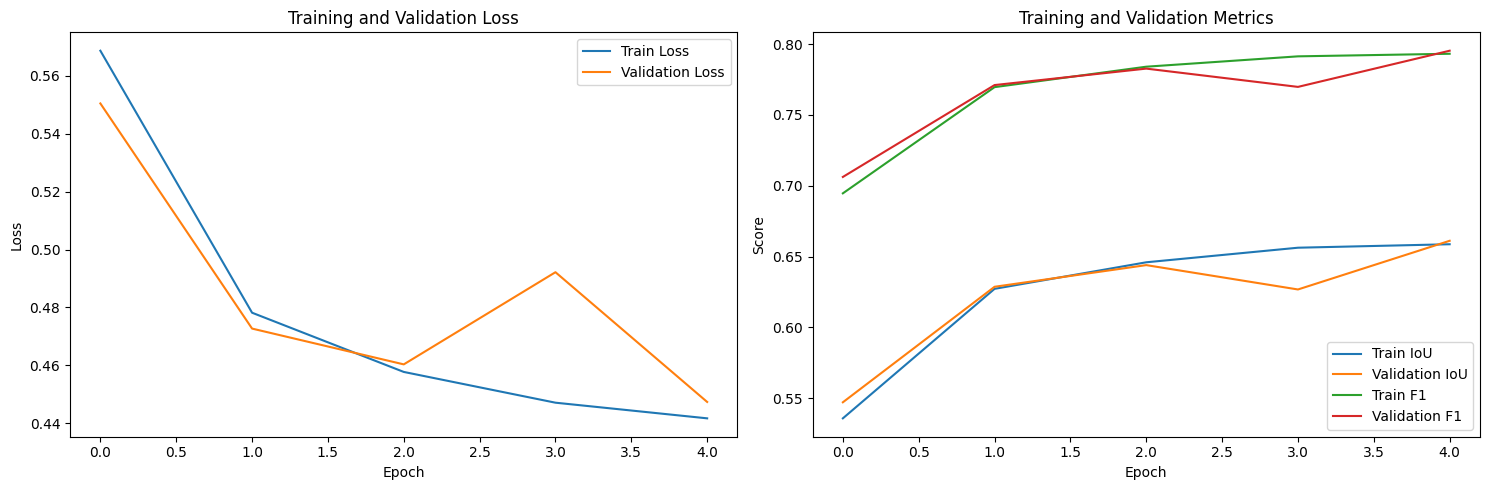

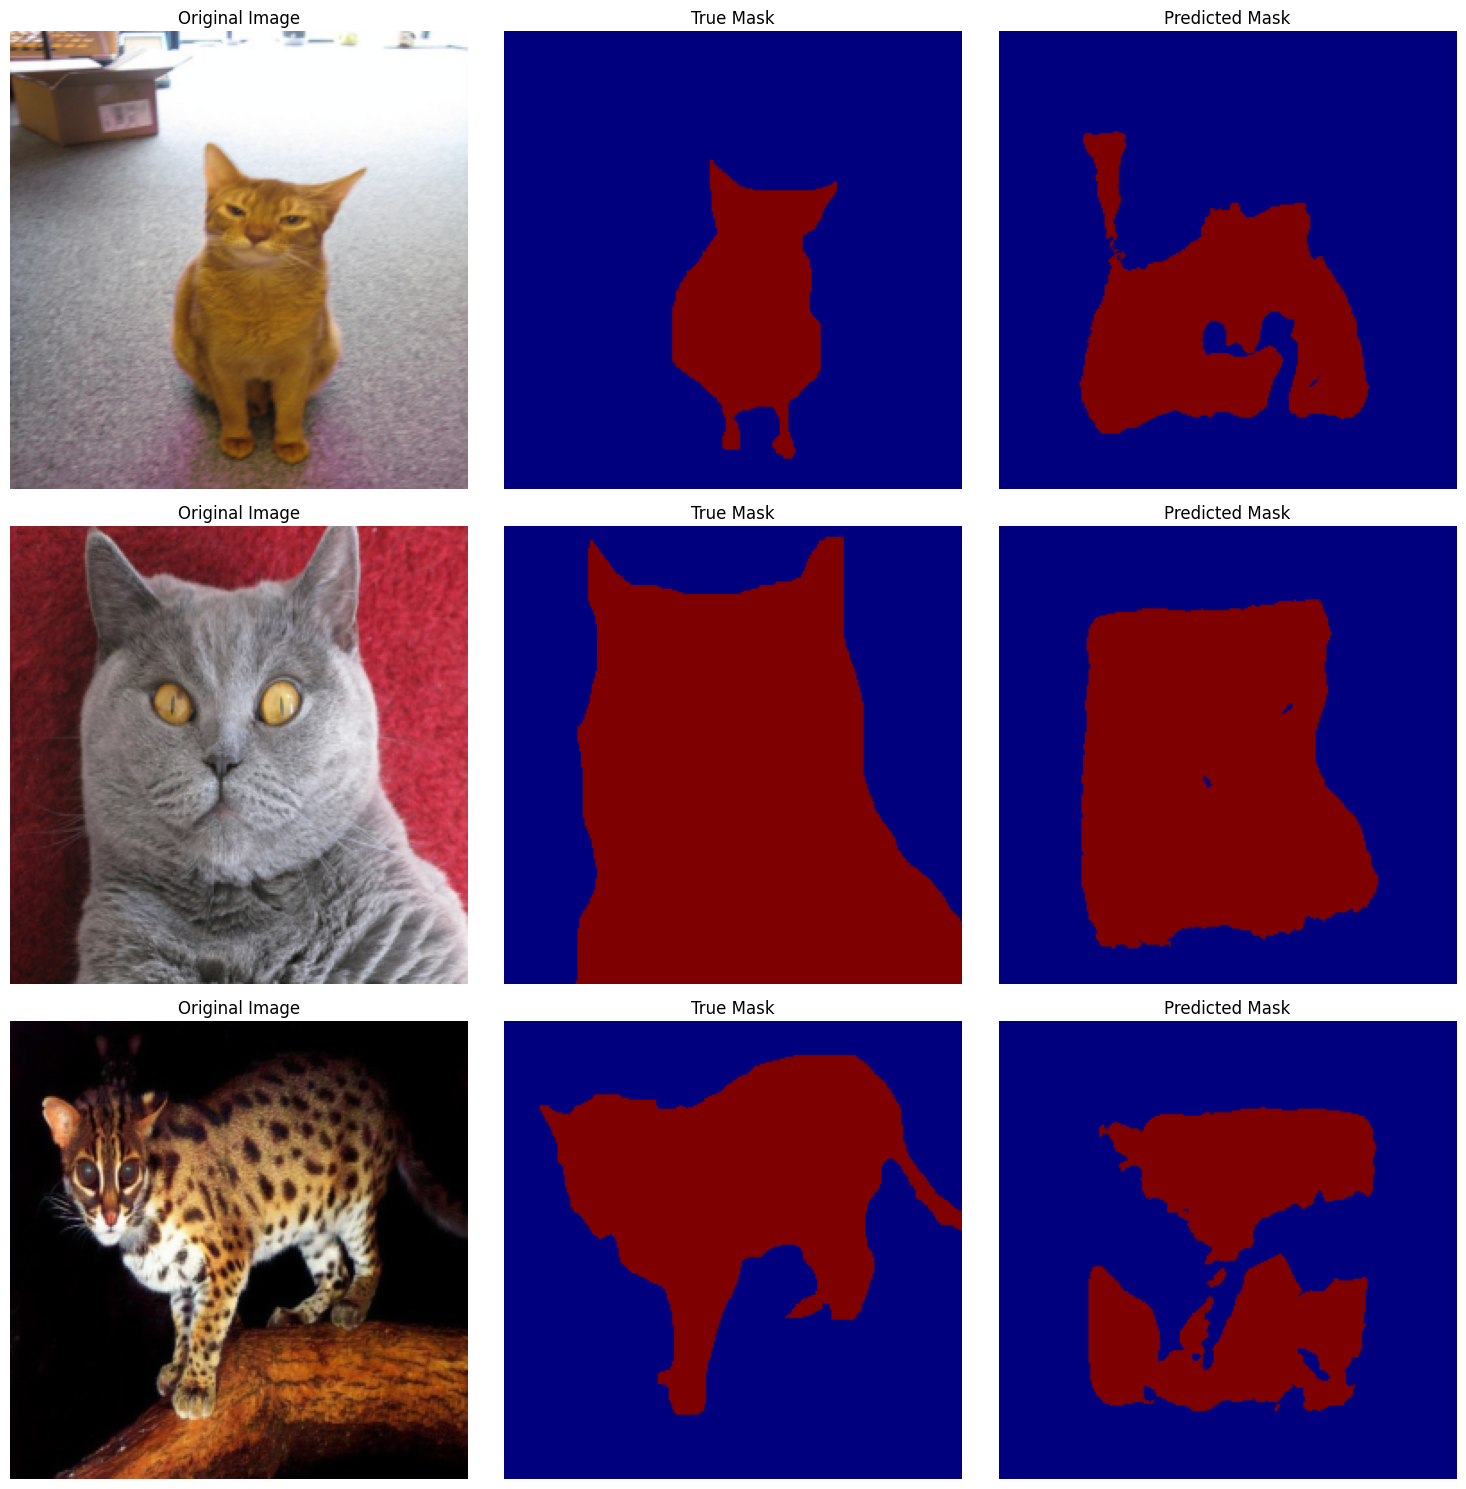

In [51]:
# Визуализация результатов обучения
plot_training_history(custom_history)

# Визуализация предсказаний
visualize_predictions(custom_model, val_dataset)

### Оценка качества имплементированной модели

In [52]:
# Финальная оценка
val_loss_custom, val_iou_custom, val_f1_custom, val_acc_custom = evaluate_model(
    custom_model, val_loader, criterion
)

custom_results = {
    'loss': val_loss_custom,
    'iou': val_iou_custom,
    'f1': val_f1_custom,
    'accuracy': val_acc_custom
}

Validation Loss: 0.4474
IoU: 0.6611
F1 Score: 0.7954
Accuracy: 0.7954


### Сравнение с бейзлайном

In [53]:
print("Comparison between Baseline and Custom Models:")
print(f"Metric\t\tBaseline\tCustom\t\tDifference")
print(f"Loss\t\t{baseline_results['loss']:.4f}\t\t{custom_results['loss']:.4f}\t\t{custom_results['loss'] - baseline_results['loss']:.4f}")
print(f"IoU\t\t{baseline_results['iou']:.4f}\t\t{custom_results['iou']:.4f}\t\t{custom_results['iou'] - baseline_results['iou']:.4f}")
print(f"F1\t\t{baseline_results['f1']:.4f}\t\t{custom_results['f1']:.4f}\t\t{custom_results['f1'] - baseline_results['f1']:.4f}")
print(f"Accuracy\t{baseline_results['accuracy']:.4f}\t\t{custom_results['accuracy']:.4f}\t\t{custom_results['accuracy'] - baseline_results['accuracy']:.4f}")


Comparison between Baseline and Custom Models:
Metric		Baseline	Custom		Difference
Loss		0.1743		0.4474		0.2731
IoU		0.8791		0.6611		-0.2180
F1		0.9352		0.7954		-0.1399
Accuracy	0.9352		0.7954		-0.1399
